# Generating Digits with a Conditional Diffusion Model

This notebook provides you with a complete code example to generate MNIST digits with a conditional diffusion model.

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [1]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True),
])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)

... and plot some of the transformed MNIST digits.

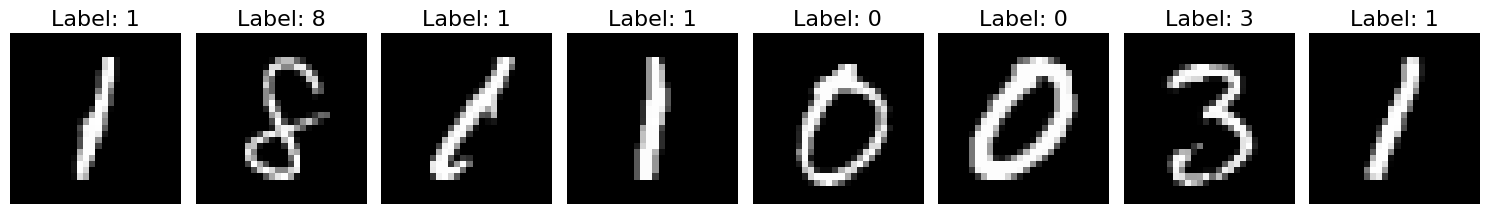

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=16)
	ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process and 

Define the device on which the computations are performed ...

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

mps


... implement the forward diffusion process ...

In [5]:
class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [6]:
diffusion = Diffusion(noise_steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]

noisy_images = []
for i in range(len(time_steps)):
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), 
        t=torch.tensor([time_steps[i]]).to(device)
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

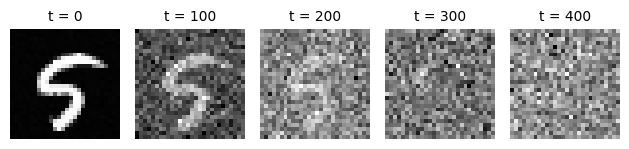

In [7]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {time_steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [8]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02,
                 img_size=28, device=device):
        """Initialize the diffusion model."""
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        """Prepare the noise schedule."""
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels,
                          position_encoding_dim, position_encoding_function,
                          fixed_noise=None, save_time_steps=None, 
                          class_labels=None, guidance_strength=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                )
                x = x.to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.noise_steps)),
                          desc="U-Net inference", total=self.noise_steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = position_encoding_function(
                    t.unsqueeze(1), position_encoding_dim
                ).to(self.device)

                if class_labels is None:
                    predicted_noise = model(x, t_pos_enc)
                else:
                    conditional_prediction = model(x, t_pos_enc, class_labels)
                    unconditional_prediction = model(x, t_pos_enc, None)
                    predicted_noise = torch.lerp(unconditional_prediction,
                                                 conditional_prediction,
                                                 guidance_strength)

                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                
                if i > 0:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                    
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                    / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                    + torch.sqrt(1-alpha) * noise)

                if i in save_time_steps:
                    denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Defining the Position Encoding Function

Implement the position encoding function ...

In [9]:
def positional_encoding(t, enc_dim):
    """Encode position informaiton with a sinusoid."""
    inv_freq = 1.0 / (10000 ** (torch.arange(0, enc_dim, 2).float() 
                                / enc_dim)).to(t.device)
    pos_enc_a = torch.sin(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc_b = torch.cos(t.repeat(1, enc_dim // 2) * inv_freq)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [10]:
position_encoding_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, position_encoding_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

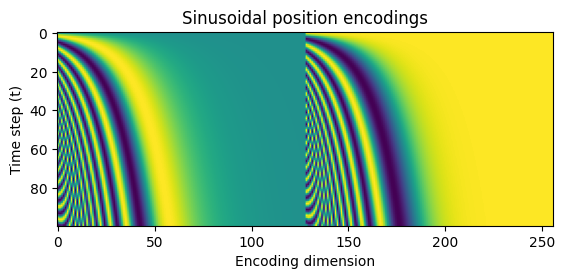

In [11]:
fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.title("Sinusoidal position encodings")
plt.show()


## Defining the Attention U-Net

In [12]:
import deeplay as dl

position_encoding_dim = 256

unet = dl.AttentionUNet(
    in_channels=1,
    channels=[32, 64, 128],
    base_channels=[256, 256],
    channel_attention=[True, True, True],
    out_channels=1,
    position_embedding_dim=position_encoding_dim,
    num_classes=10,
)
unet.build()
unet.to(device);

print(unet)

AttentionUNet(
  (class_embedding): Embedding(10, 256)
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approx

## Training the Diffusion Model

Define the data loader ...

In [13]:
from torch.utils.data import DataLoader

batch_size = 128
loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

... define the loss function ...

In [14]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [15]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

...  instantiate the diffusion class for training ...

In [16]:
noise_steps = 1000

diffusion = Diffusion(
    noise_steps=noise_steps,
    img_size=28,
    beta_start=1e-4,
    beta_end=0.02,
)

...implement a function to prepare the data ...

In [17]:
def prepare_data(image, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    
    t = torch.randint(low=0, high=noise_steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t = positional_encoding(t.unsqueeze(1), position_encoding_dim)
    
    return x_t.to(device), t.to(device), noise.to(device)

... implement the training cycle ...


Epoch 1/20
__________
Batch 1/469: Train loss: 1.5037
Batch 101/469: Train loss: 0.1410
Batch 201/469: Train loss: 0.1065
Batch 301/469: Train loss: 0.0735
Batch 401/469: Train loss: 0.0759
----------
Epoch 1/20 : Train loss: 0.1409, Time taken: 0:05:26.066143


U-Net inference: 100%|██████████| 1000/1000 [00:57<00:00, 17.37it/s]


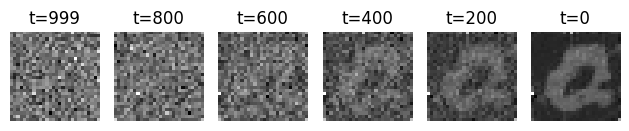

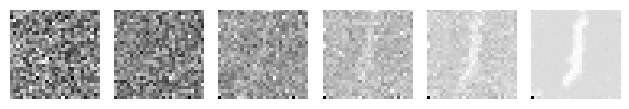

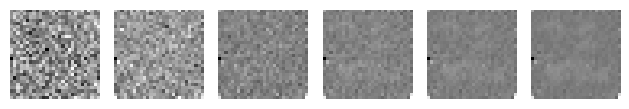

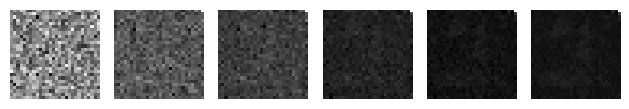

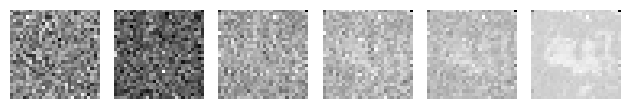

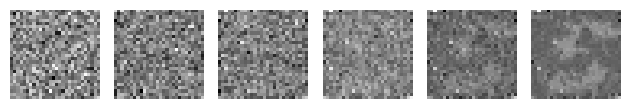

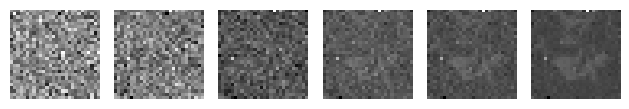

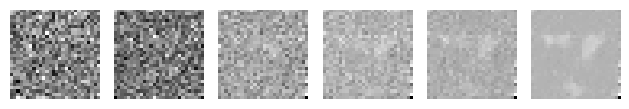

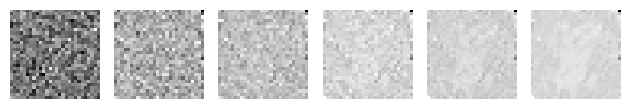

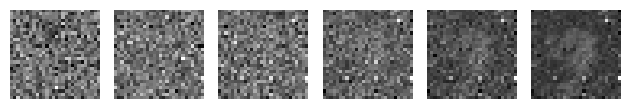


Epoch 2/20
__________
Batch 1/469: Train loss: 0.0646
Batch 101/469: Train loss: 0.0757
Batch 201/469: Train loss: 0.0741
Batch 301/469: Train loss: 0.0421
Batch 401/469: Train loss: 0.0442
----------
Epoch 2/20 : Train loss: 0.0511, Time taken: 0:05:25.051950


U-Net inference: 100%|██████████| 1000/1000 [00:56<00:00, 17.84it/s]


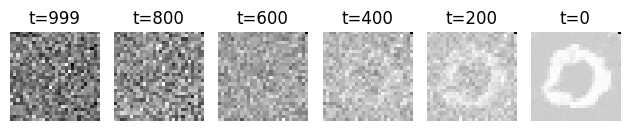

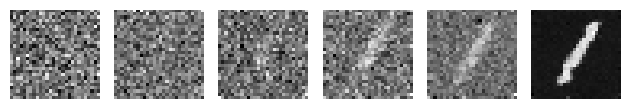

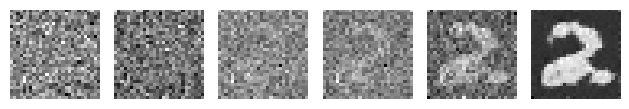

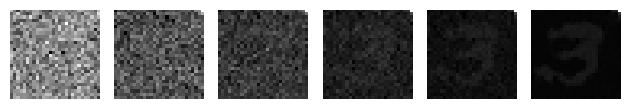

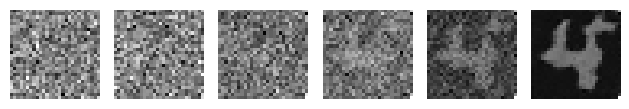

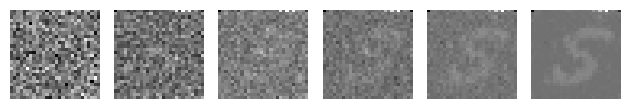

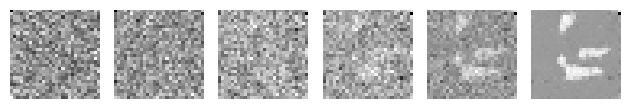

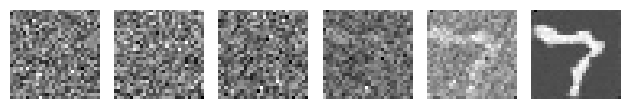

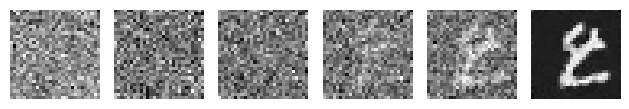

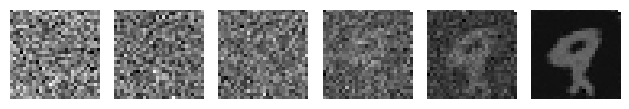


Epoch 3/20
__________
Batch 1/469: Train loss: 0.0504
Batch 101/469: Train loss: 0.0375
Batch 201/469: Train loss: 0.0388
Batch 301/469: Train loss: 0.0362
Batch 401/469: Train loss: 0.0355
----------
Epoch 3/20 : Train loss: 0.0413, Time taken: 0:05:25.244737


U-Net inference: 100%|██████████| 1000/1000 [00:55<00:00, 18.11it/s]


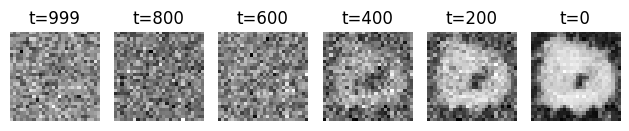

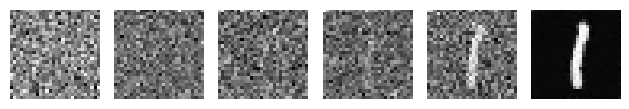

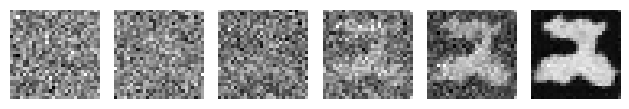

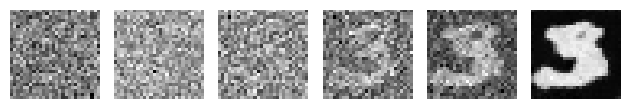

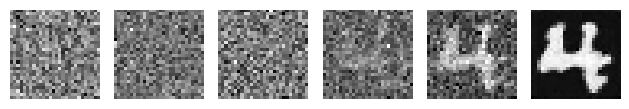

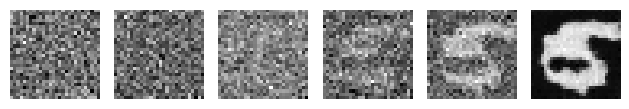

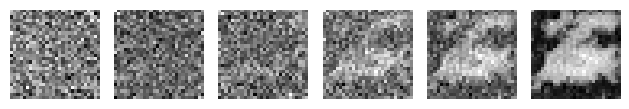

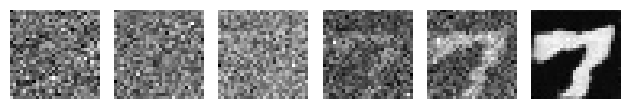

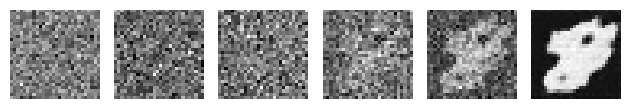

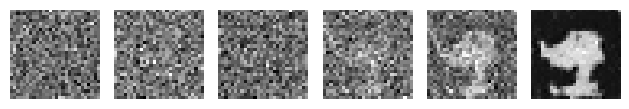


Epoch 4/20
__________
Batch 1/469: Train loss: 0.0434
Batch 101/469: Train loss: 0.0357
Batch 201/469: Train loss: 0.0331
Batch 301/469: Train loss: 0.0400
Batch 401/469: Train loss: 0.0338
----------
Epoch 4/20 : Train loss: 0.0373, Time taken: 0:05:29.119825


U-Net inference: 100%|██████████| 1000/1000 [00:52<00:00, 19.11it/s]


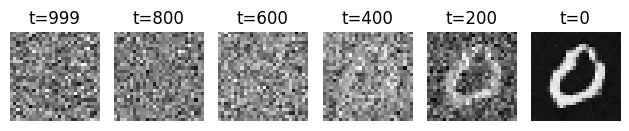

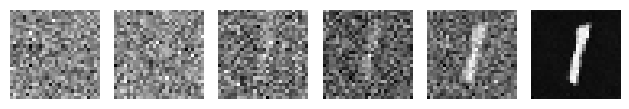

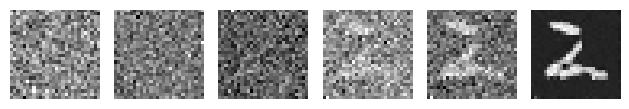

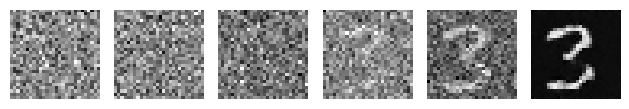

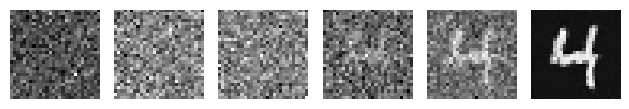

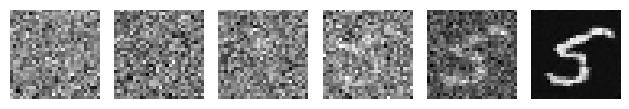

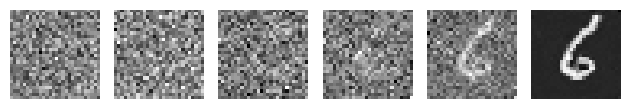

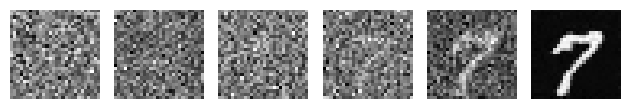

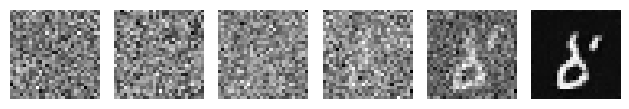

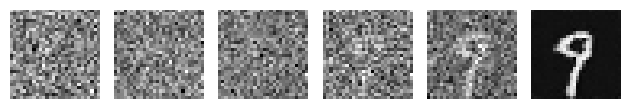


Epoch 5/20
__________
Batch 1/469: Train loss: 0.0297
Batch 101/469: Train loss: 0.0377
Batch 201/469: Train loss: 0.0386
Batch 301/469: Train loss: 0.0327
Batch 401/469: Train loss: 0.0330
----------
Epoch 5/20 : Train loss: 0.0349, Time taken: 0:05:23.608999


U-Net inference: 100%|██████████| 1000/1000 [00:53<00:00, 18.76it/s]


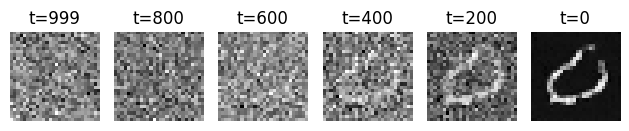

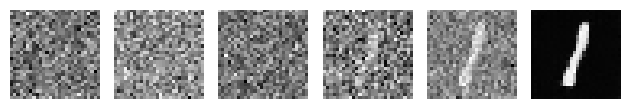

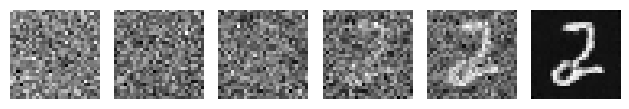

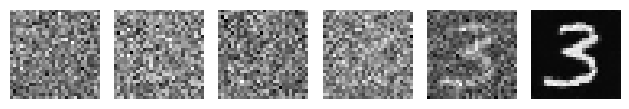

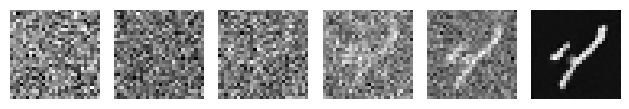

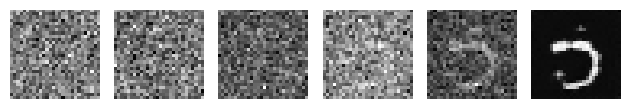

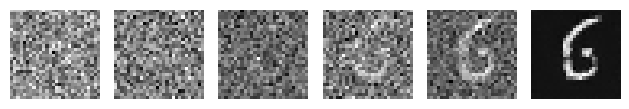

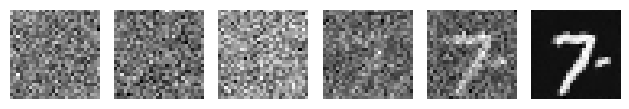

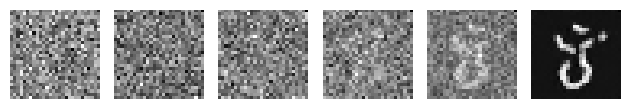

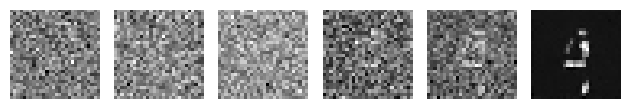


Epoch 6/20
__________
Batch 1/469: Train loss: 0.0292
Batch 101/469: Train loss: 0.0354
Batch 201/469: Train loss: 0.0307
Batch 301/469: Train loss: 0.0324
Batch 401/469: Train loss: 0.0326
----------
Epoch 6/20 : Train loss: 0.0317, Time taken: 0:05:19.194648


U-Net inference: 100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


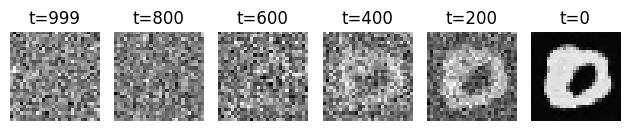

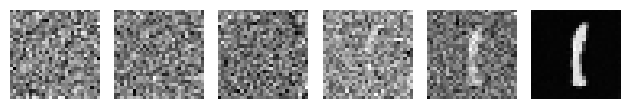

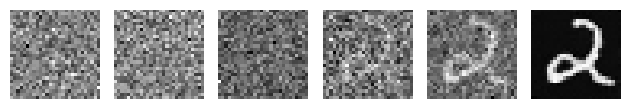

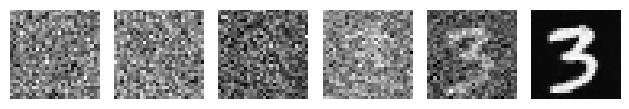

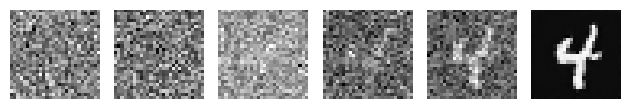

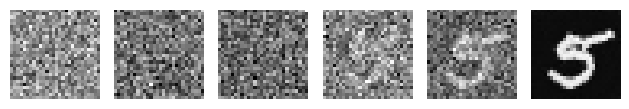

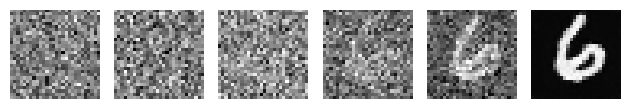

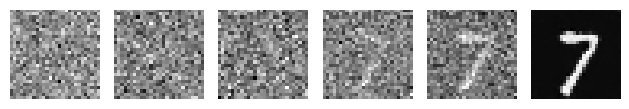

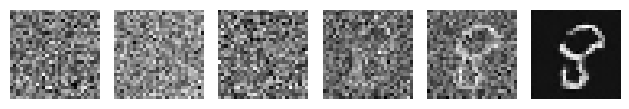

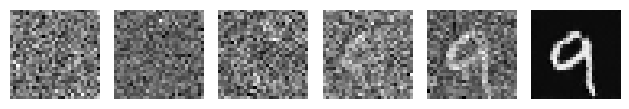


Epoch 7/20
__________
Batch 1/469: Train loss: 0.0348
Batch 101/469: Train loss: 0.0287
Batch 201/469: Train loss: 0.0341
Batch 301/469: Train loss: 0.0350
Batch 401/469: Train loss: 0.0315
----------
Epoch 7/20 : Train loss: 0.0309, Time taken: 0:05:19.804976


U-Net inference: 100%|██████████| 1000/1000 [00:54<00:00, 18.29it/s]


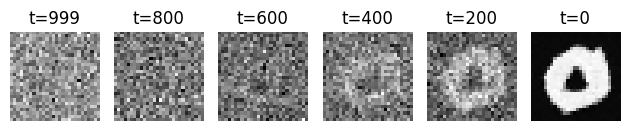

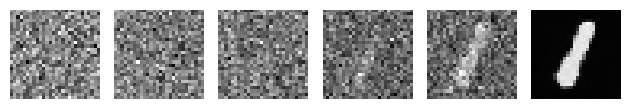

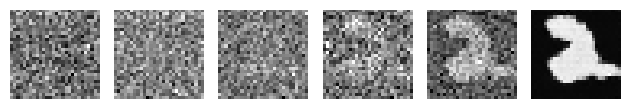

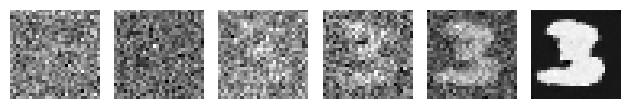

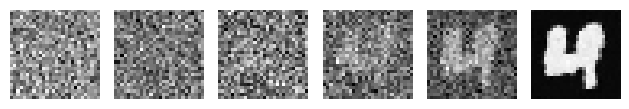

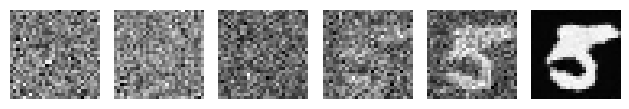

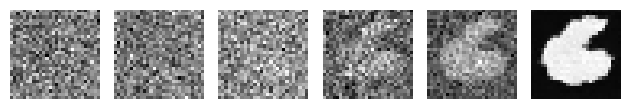

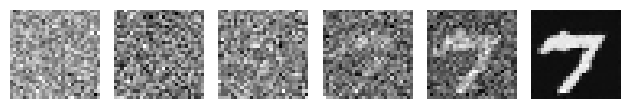

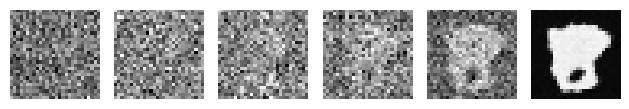

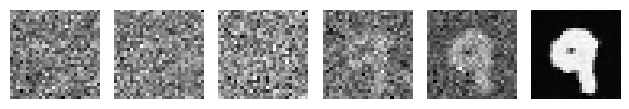


Epoch 8/20
__________
Batch 1/469: Train loss: 0.0356
Batch 101/469: Train loss: 0.0360
Batch 201/469: Train loss: 0.0300
Batch 301/469: Train loss: 0.0301
Batch 401/469: Train loss: 0.0319
----------
Epoch 8/20 : Train loss: 0.0299, Time taken: 0:05:19.477660


U-Net inference: 100%|██████████| 1000/1000 [00:54<00:00, 18.39it/s]


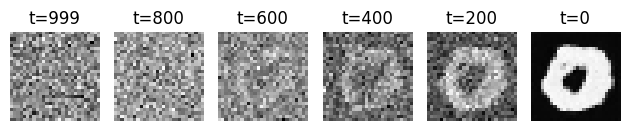

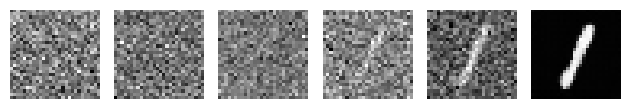

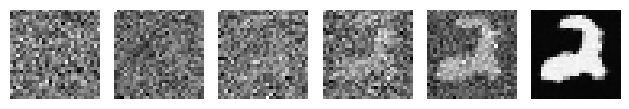

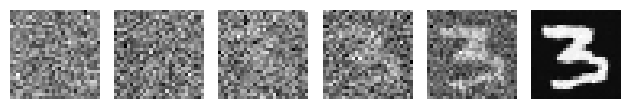

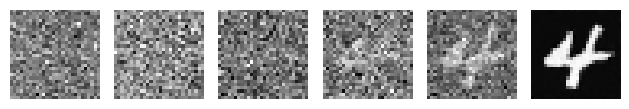

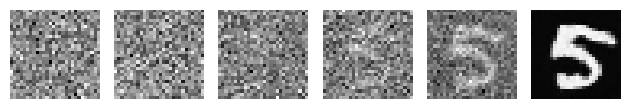

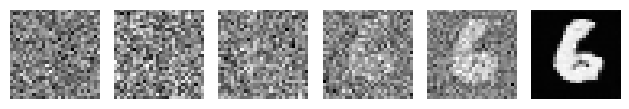

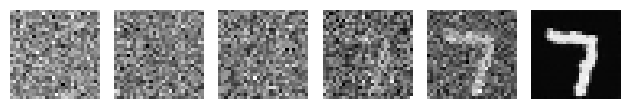

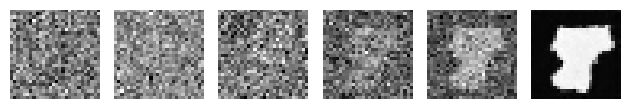

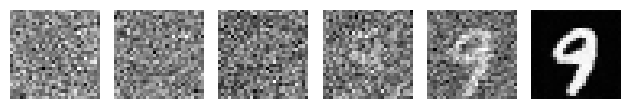


Epoch 9/20
__________
Batch 1/469: Train loss: 0.0328
Batch 101/469: Train loss: 0.0336
Batch 201/469: Train loss: 0.0242
Batch 301/469: Train loss: 0.0268
Batch 401/469: Train loss: 0.0304
----------
Epoch 9/20 : Train loss: 0.0287, Time taken: 0:05:22.736753


U-Net inference: 100%|██████████| 1000/1000 [00:57<00:00, 17.43it/s]


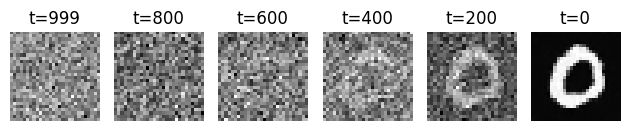

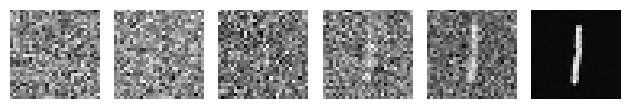

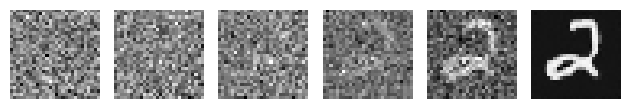

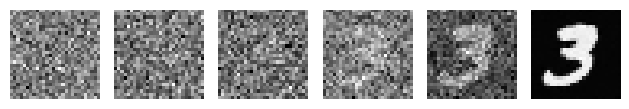

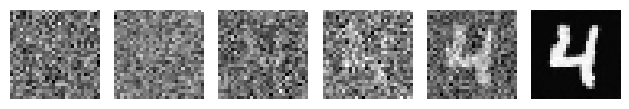

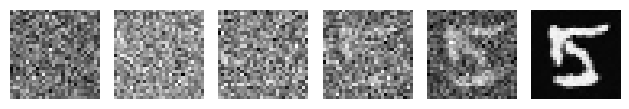

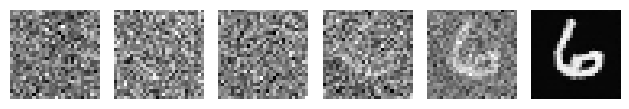

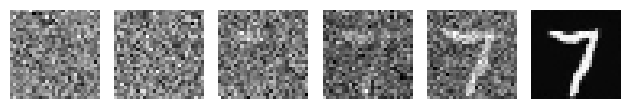

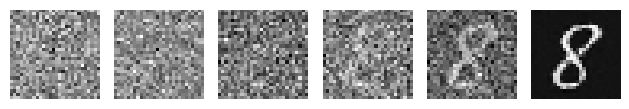

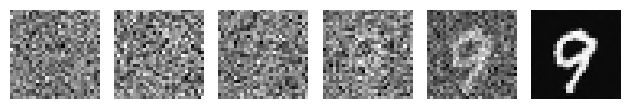


Epoch 10/20
__________
Batch 1/469: Train loss: 0.0284
Batch 101/469: Train loss: 0.0243
Batch 201/469: Train loss: 0.0276
Batch 301/469: Train loss: 0.0267
Batch 401/469: Train loss: 0.0218
----------
Epoch 10/20 : Train loss: 0.0282, Time taken: 0:05:25.420338


U-Net inference: 100%|██████████| 1000/1000 [00:56<00:00, 17.69it/s]


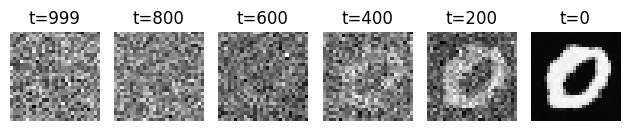

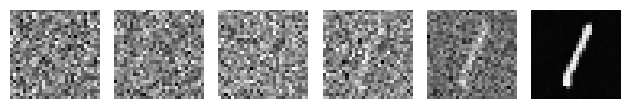

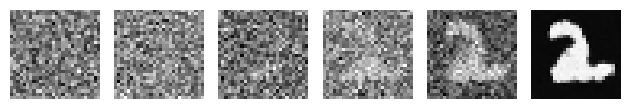

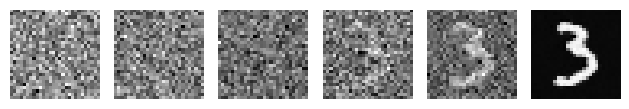

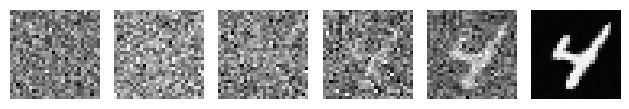

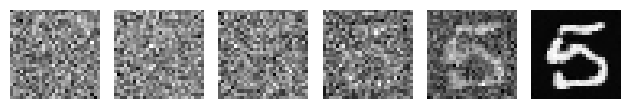

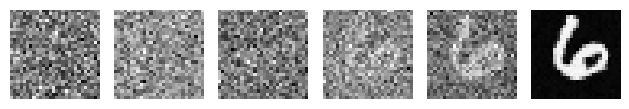

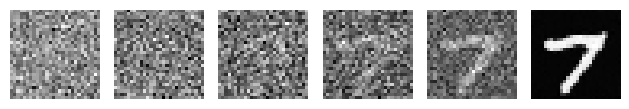

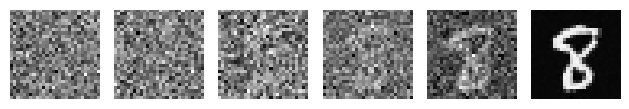

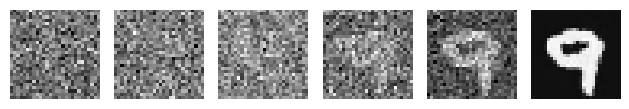


Epoch 11/20
__________
Batch 1/469: Train loss: 0.0340
Batch 101/469: Train loss: 0.0247
Batch 201/469: Train loss: 0.0325
Batch 301/469: Train loss: 0.0246
Batch 401/469: Train loss: 0.0213
----------
Epoch 11/20 : Train loss: 0.0276, Time taken: 0:05:24.689051


U-Net inference: 100%|██████████| 1000/1000 [00:55<00:00, 17.90it/s]


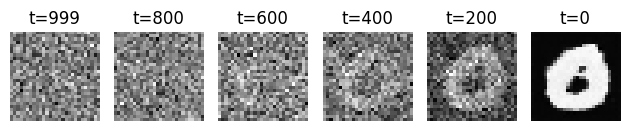

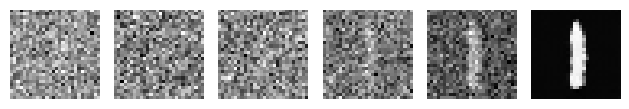

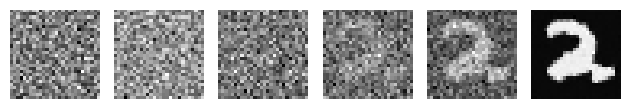

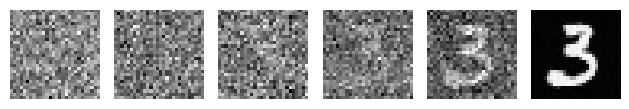

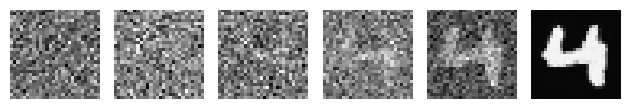

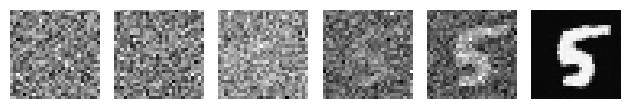

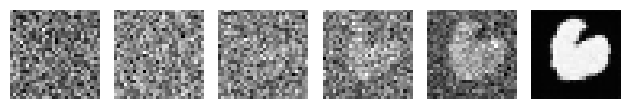

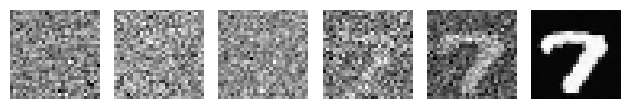

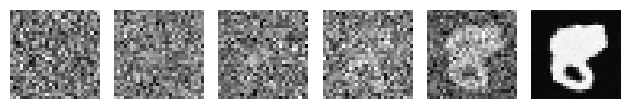

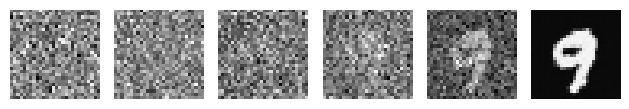


Epoch 12/20
__________
Batch 1/469: Train loss: 0.0219
Batch 101/469: Train loss: 0.0310
Batch 201/469: Train loss: 0.0337
Batch 301/469: Train loss: 0.0269
Batch 401/469: Train loss: 0.0234
----------
Epoch 12/20 : Train loss: 0.0273, Time taken: 0:05:22.211899


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.89it/s]


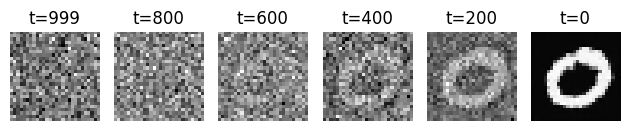

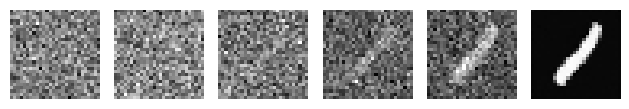

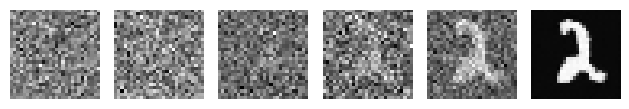

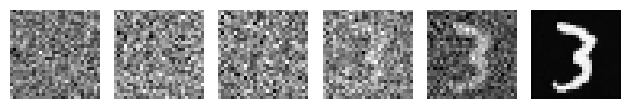

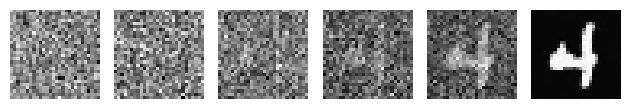

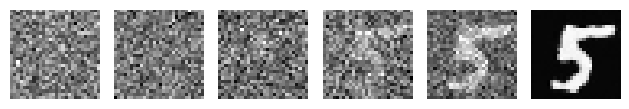

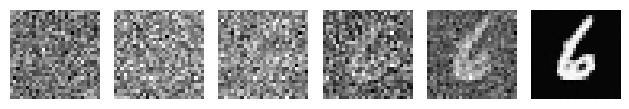

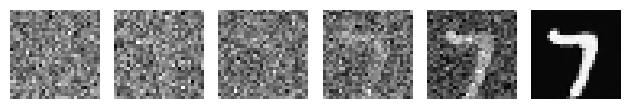

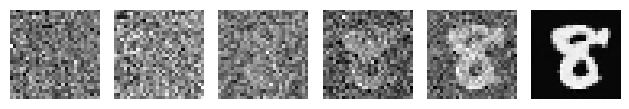

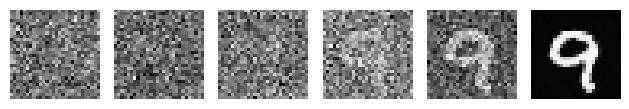


Epoch 13/20
__________
Batch 1/469: Train loss: 0.0294
Batch 101/469: Train loss: 0.0282
Batch 201/469: Train loss: 0.0240
Batch 301/469: Train loss: 0.0239
Batch 401/469: Train loss: 0.0264
----------
Epoch 13/20 : Train loss: 0.0263, Time taken: 0:03:54.530343


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.94it/s]


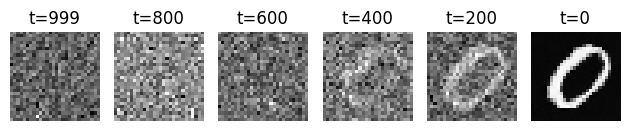

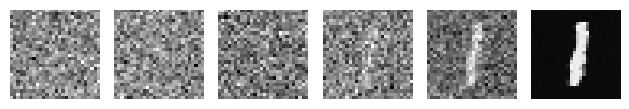

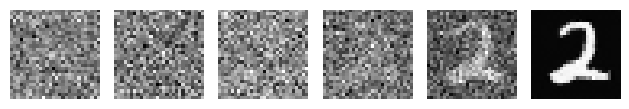

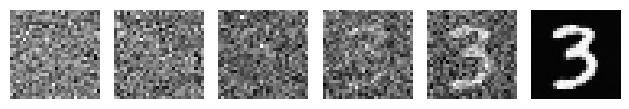

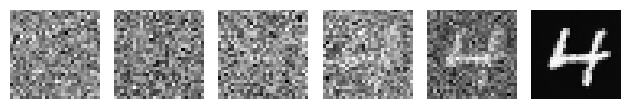

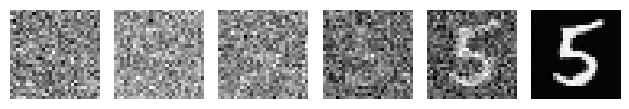

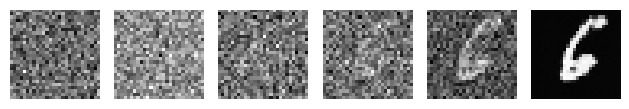

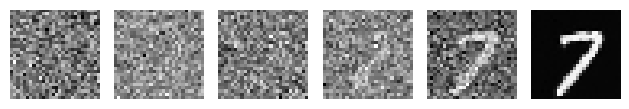

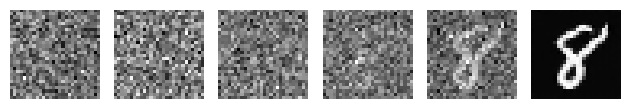

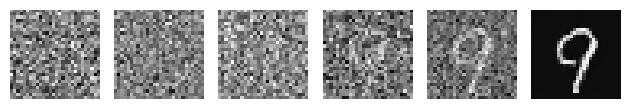


Epoch 14/20
__________
Batch 1/469: Train loss: 0.0251
Batch 101/469: Train loss: 0.0255
Batch 201/469: Train loss: 0.0263
Batch 301/469: Train loss: 0.0261
Batch 401/469: Train loss: 0.0341
----------
Epoch 14/20 : Train loss: 0.0259, Time taken: 0:03:54.574273


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]


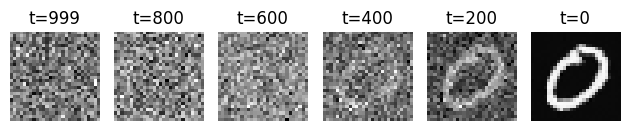

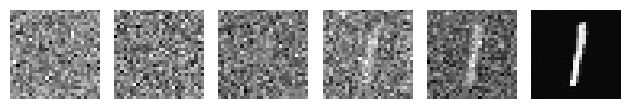

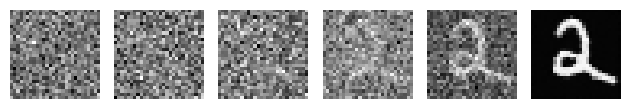

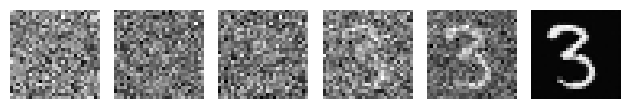

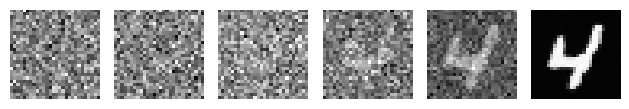

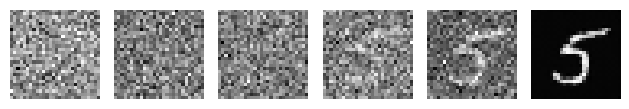

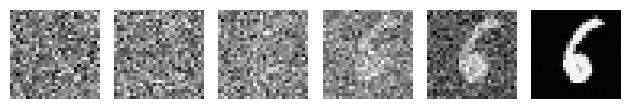

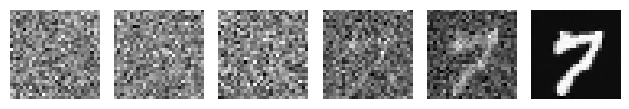

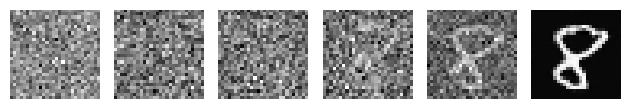

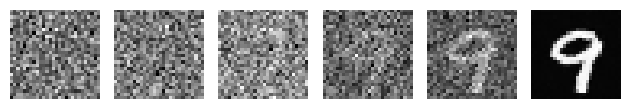


Epoch 15/20
__________
Batch 1/469: Train loss: 0.0269
Batch 101/469: Train loss: 0.0293
Batch 201/469: Train loss: 0.0371
Batch 301/469: Train loss: 0.0281
Batch 401/469: Train loss: 0.0246
----------
Epoch 15/20 : Train loss: 0.0256, Time taken: 0:03:59.183620


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.84it/s]


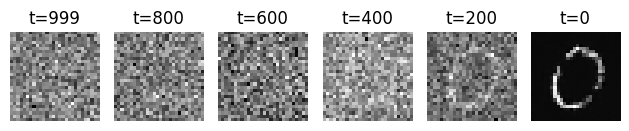

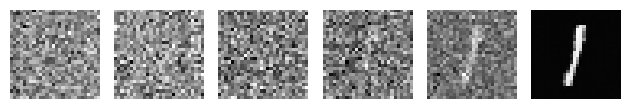

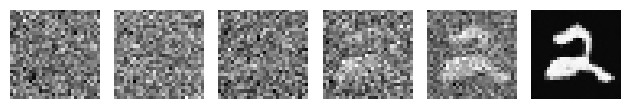

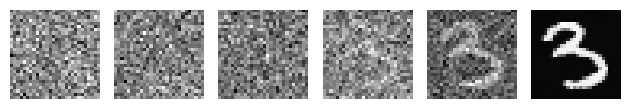

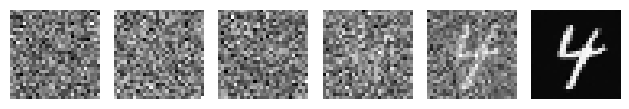

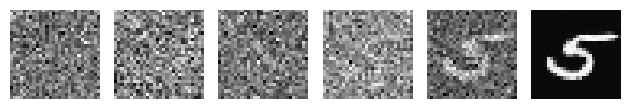

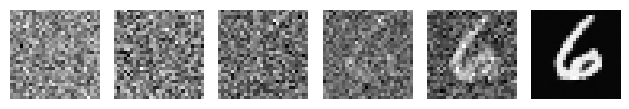

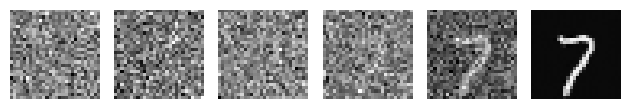

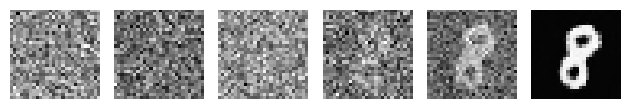

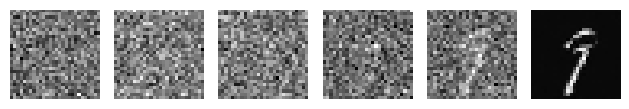


Epoch 16/20
__________
Batch 1/469: Train loss: 0.0237
Batch 101/469: Train loss: 0.0267
Batch 201/469: Train loss: 0.0277
Batch 301/469: Train loss: 0.0191
Batch 401/469: Train loss: 0.0235
----------
Epoch 16/20 : Train loss: 0.0254, Time taken: 0:03:55.019945


U-Net inference: 100%|██████████| 1000/1000 [00:48<00:00, 20.43it/s]


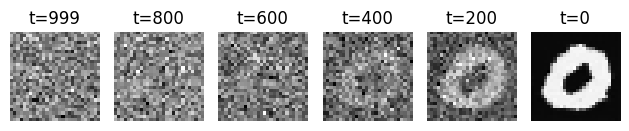

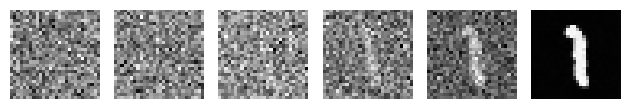

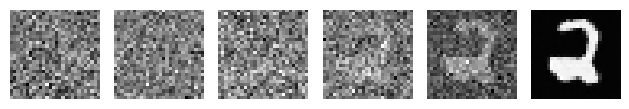

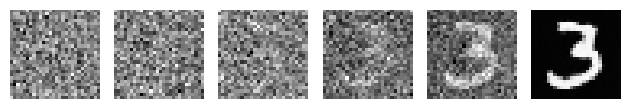

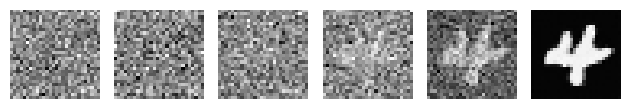

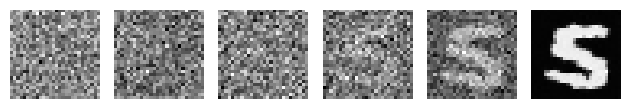

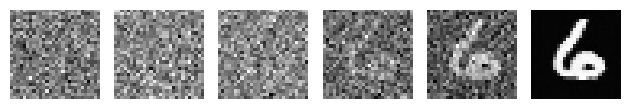

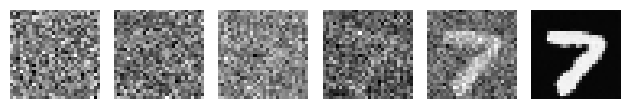

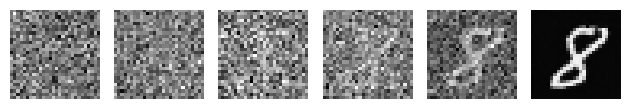

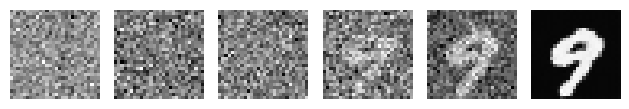


Epoch 17/20
__________
Batch 1/469: Train loss: 0.0251
Batch 101/469: Train loss: 0.0203
Batch 201/469: Train loss: 0.0301
Batch 301/469: Train loss: 0.0231
Batch 401/469: Train loss: 0.0223
----------
Epoch 17/20 : Train loss: 0.0249, Time taken: 0:03:54.578956


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.92it/s]


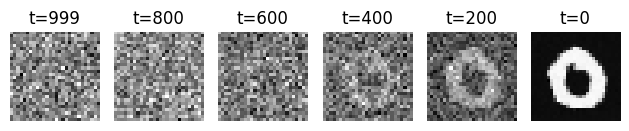

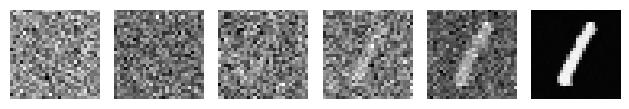

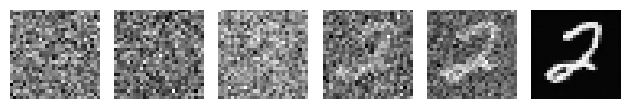

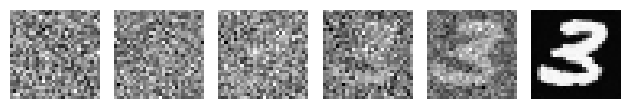

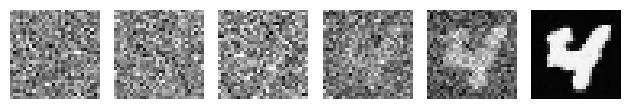

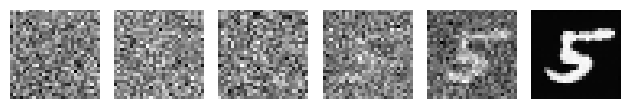

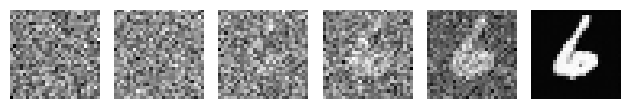

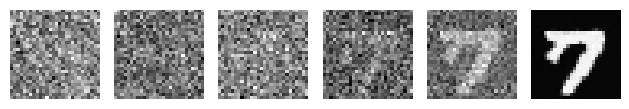

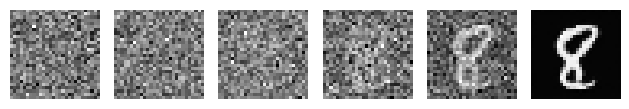

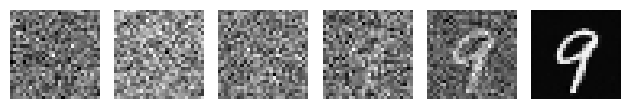


Epoch 18/20
__________
Batch 1/469: Train loss: 0.0185
Batch 101/469: Train loss: 0.0227
Batch 201/469: Train loss: 0.0279
Batch 301/469: Train loss: 0.0256
Batch 401/469: Train loss: 0.0269
----------
Epoch 18/20 : Train loss: 0.0250, Time taken: 0:03:54.505270


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.89it/s]


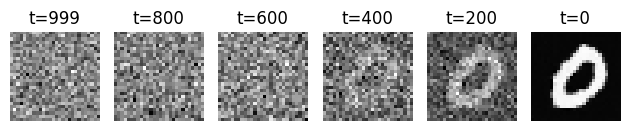

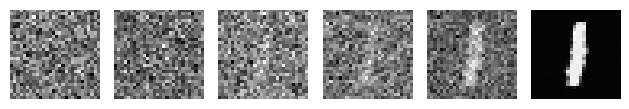

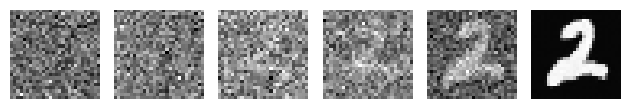

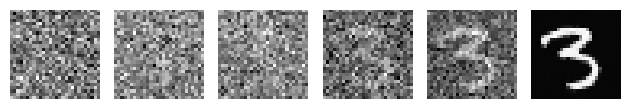

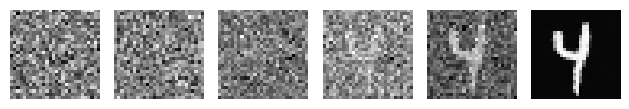

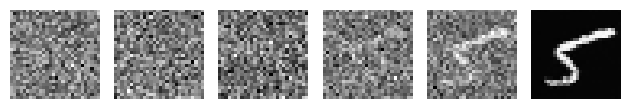

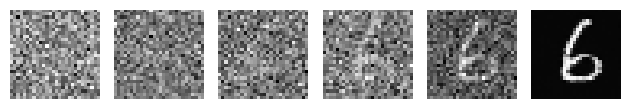

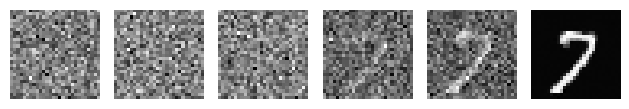

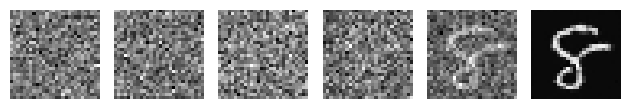

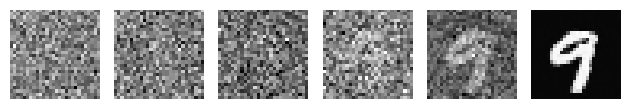


Epoch 19/20
__________
Batch 1/469: Train loss: 0.0259
Batch 101/469: Train loss: 0.0267
Batch 201/469: Train loss: 0.0242
Batch 301/469: Train loss: 0.0270
Batch 401/469: Train loss: 0.0273
----------
Epoch 19/20 : Train loss: 0.0251, Time taken: 0:03:54.620701


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.95it/s]


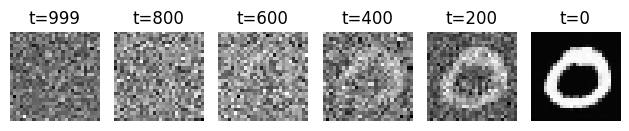

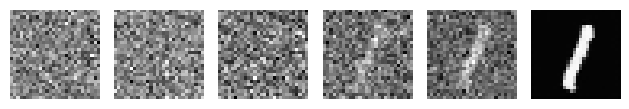

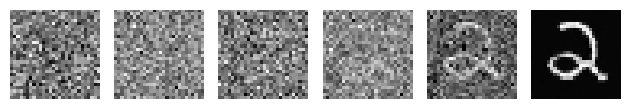

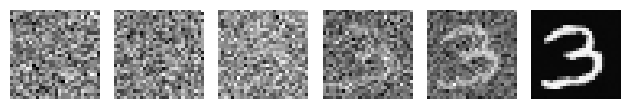

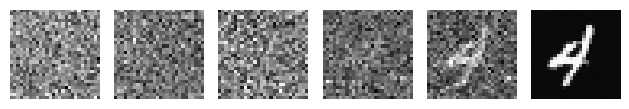

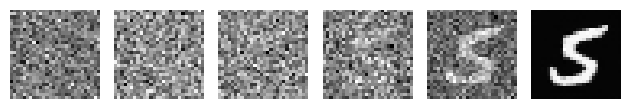

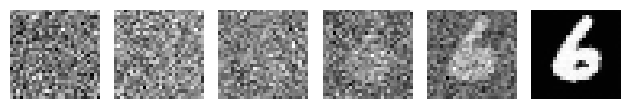

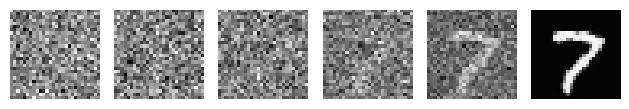

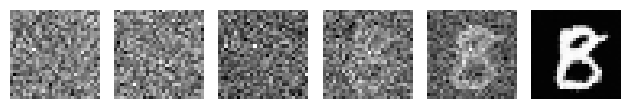

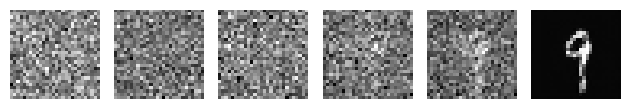


Epoch 20/20
__________
Batch 1/469: Train loss: 0.0230
Batch 101/469: Train loss: 0.0237
Batch 201/469: Train loss: 0.0242
Batch 301/469: Train loss: 0.0277
Batch 401/469: Train loss: 0.0282
----------
Epoch 20/20 : Train loss: 0.0245, Time taken: 0:03:54.618976


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.96it/s]


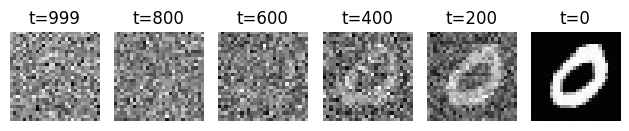

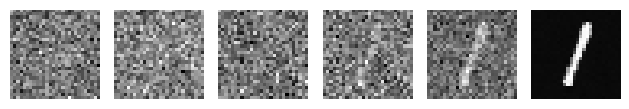

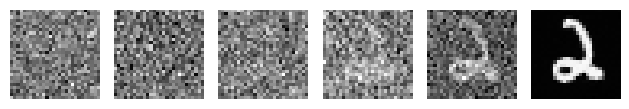

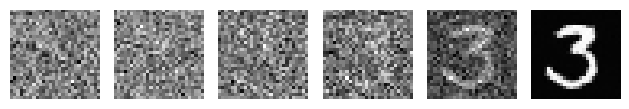

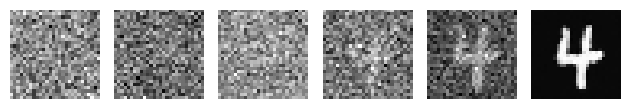

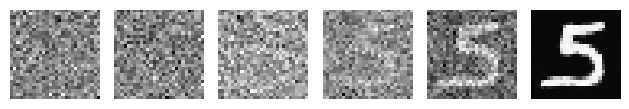

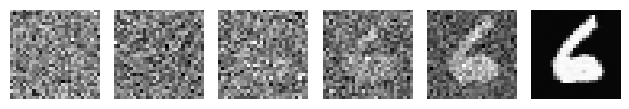

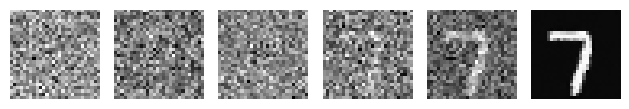

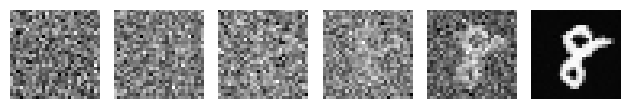

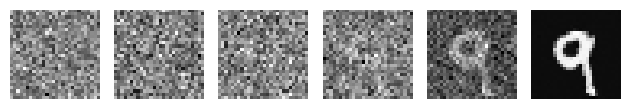

In [18]:
import numpy as np
import time
from datetime import timedelta

epochs = 20

train_loss = []
for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
        
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t, noise = prepare_data(images)
        
        class_labels = class_labels.to(device)
        if np.random.rand() < 0.1:
            class_labels = None

        outputs = unet(x_t, t, class_labels)
        
        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    n_images = 10
    class_labels = torch.arange(0, 10).long().to(device)
    save_time_steps = [999, 800, 600, 400, 200, 0]
    generated_images = diffusion.reverse_diffusion(
        model=unet,
        n_images=n_images,
        n_channels=1,
        position_encoding_dim=position_encoding_dim,
        position_encoding_function=positional_encoding,
        save_time_steps=save_time_steps,
        class_labels=class_labels,
        guidance_strength=3,
    )

    for i in range(n_images):
        fig, axs = plt.subplots(1, len(save_time_steps))
        for j in range(len(save_time_steps)):
            axs[j].imshow(generated_images[i, j]
                .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            if i == 0: axs[j].set_title(f"t={save_time_steps[j]}")
            axs[j].axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

## Plotting the Training loss

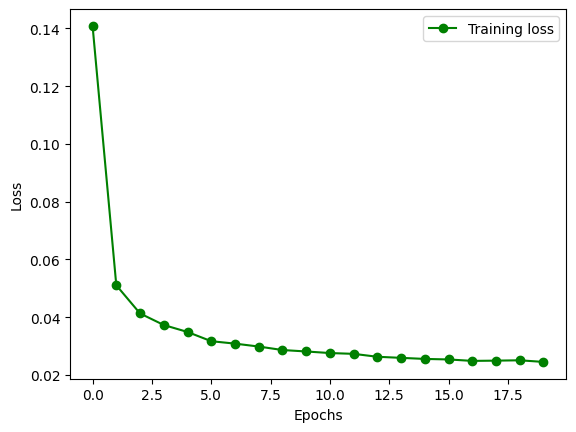

In [19]:
plt.figure()
plt.plot(train_loss, "g-o", label="Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()